# LIBRARIES, DATA, AND PREPROCESSING

## Librairies

In [2]:
import sys
print(sys.executable)
!{sys.executable} -m pip install yfinance
import yfinance as yf
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")


c:\Users\Emile\anaconda3\python.exe


## Import Data + CSV generation

In [3]:
tickers = {
    "DJ30": "^DJI",     # Dow Jones Industrial Average
    "SNP500": "^GSPC",  # S&P 500 Index
    "CAC40": "^FCHI"    # CAC 40 Index
}
start_date = "2018-01-01"
end_date = "2025-01-01"

for name, symbol in tickers.items():
    # Download data
    data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
    
    # Rename columns with prefix, e.g. "CAC40_Open", "CAC40_Close", etc.
    data = data.rename(columns={col: f"{name}__{col}" for col in data.columns})
    
    # Save to CSV
    filename = f"{name}_data.csv"
    data.to_csv(filename, index=True)
    print(data.head(), "\n")


C:\Users\Emile\AppData\Local\Temp\ipykernel_30752\4262377256.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed
C:\Users\Emile\AppData\Local\Temp\ipykernel_30752\4262377256.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]


Price               Open          High           Low         Close     Volume
Ticker              ^DJI          ^DJI          ^DJI          ^DJI       ^DJI
Date                                                                         
2018-01-02  24809.349609  24864.189453  24741.699219  24824.009766  341130000
2018-01-03  24850.449219  24941.919922  24825.550781  24922.679688  456790000
2018-01-04  24964.859375  25105.960938  24963.269531  25075.130859  403280000
2018-01-05  25114.919922  25299.789062  25112.009766  25295.869141  358020000
2018-01-08  25308.400391  25311.990234  25235.410156  25283.000000  341390000 



[*********************100%***********************]  1 of 1 completed
C:\Users\Emile\AppData\Local\Temp\ipykernel_30752\4262377256.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]


Price              Open         High          Low        Close      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059  3397430000
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059  3544030000
2018-01-04  2719.310059  2729.290039  2719.070068  2723.989990  3697340000
2018-01-05  2731.330078  2743.449951  2727.919922  2743.149902  3239280000
2018-01-08  2742.669922  2748.510010  2737.600098  2747.709961  3246160000 



[*********************100%***********************]  1 of 1 completed

Price              Open         High          Low        Close    Volume
Ticker            ^FCHI        ^FCHI        ^FCHI        ^FCHI     ^FCHI
Date                                                                    
2018-01-02  5318.740234  5318.740234  5258.660156  5288.600098  66802600
2018-01-03  5295.310059  5347.629883  5291.890137  5331.279785  75371700
2018-01-04  5360.009766  5430.720215  5360.009766  5413.689941  92583500
2018-01-05  5424.160156  5470.750000  5422.779785  5470.750000  76275800
2018-01-08  5483.470215  5499.149902  5478.919922  5487.419922  72318000 



## DATA PREPROCESSING

In [4]:
df_sp = pd.read_csv("SNP500_data.csv")

# Deleting useless columns
df_sp = df_sp[~df_sp["Price"].isin(["Ticker", "Date"])].copy()

#The "price" collumn are actuallt dates
df_sp["Date"] = pd.to_datetime(df_sp["Price"])
df_sp = df_sp.drop(columns=["Price"])
df_sp = df_sp.set_index("Date")

#Make sure that every column has numerical values
for col in df_sp.columns:
    df_sp[col] = pd.to_numeric(df_sp[col], errors="coerce")

print(df_sp.head())
print(df_sp.info())

                   Open         High          Low        Close      Volume
Date                                                                      
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059  3397430000
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059  3544030000
2018-01-04  2719.310059  2729.290039  2719.070068  2723.989990  3697340000
2018-01-05  2731.330078  2743.449951  2727.919922  2743.149902  3239280000
2018-01-08  2742.669922  2748.510010  2737.600098  2747.709961  3246160000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1761 non-null   float64
 1   High    1761 non-null   float64
 2   Low     1761 non-null   float64
 3   Close   1761 non-null   float64
 4   Volume  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB
None


In [5]:
#creating a copy on which we will work
data = df_sp.copy()

# returns
data["return_1d"] = data["Close"].pct_change()

# target: next day's return
data["target_return_1d"] = data["return_1d"].shift(-1)

# classification if the return is > 0 or not
data["target_direction"] = (data["target_return_1d"] > 0).astype(int)

# cleaning: remove NaN due to shifts
data = data.dropna()

# final preview
print("\nFinal dataset preview:")
display(data.head())


print("\nFinal shape:", data.shape)


Final dataset preview:


,Open,High,Low,Close,Volume,return_1d,target_return_1d,target_direction
Date,,,,,,,,
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,3544030000,0.006399,0.004029,1
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,3697340000,0.004029,0.007034,1
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,3239280000,0.007034,0.001662,1
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,3246160000,0.001662,0.001303,1
2018-01-09,2751.149902,2759.139893,2747.860107,2751.290039,3467460000,0.001303,-0.001112,0



Final shape: (1759, 8)


## SPLITTING DATA

We will split  our data in the following way :

2015–2019 → Train
2020–2022 → Validation
2023–2024 → Test


# INDICATORS

- In this section, we will create the folloiwing indicators in order to apply them to the DJ30, SNP500 and CAC40 historical data :
    - MACD
    - RSI
    - Moving Averages
    - Volumes
    - Momentum

## MACD

What is the MACD?

The Moving Average Convergence Divergence (MACD) is a **momentum indicator**
used in technical analysis to reveal changes in the strength, direction,
and duration of a trend in a stock’s price. It’s calculated as the difference
between two Exponential Moving Averages (EMAs): a short-term one (usually 12 periods)
and a long-term one (usually 26 periods). 

    The MACD line = EMA(12) – EMA(26)
    The Signal line = EMA(9) of the MACD line
    The Histogram = MACD – Signal

When the MACD crosses above the Signal line, it may indicate **bullish momentum**;
when it crosses below, it may suggest **bearish momentum**.

In [6]:
def compute_MACD(series, fast=12, slow=26, signal=9):
    """
    Compute MACD (Moving Average Convergence Divergence) indicator.
    Returns:
        macd_line, signal_line, macd_histogram
    """
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()

    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line

    return macd_line, signal_line, macd_hist

#calculate MACD on close prices
data["MACD_line"], data["MACD_signal"], data["MACD_hist"] = compute_MACD(data["Close"])

#no look-ahead bias
data["MACD_line"]   = data["MACD_line"].shift(1)
data["MACD_signal"] = data["MACD_signal"].shift(1)
data["MACD_hist"]   = data["MACD_hist"].shift(1)

#clean NaN
data = data.dropna()

display(data[["Close", "MACD_line", "MACD_signal", "MACD_hist"]].head())

,Close,MACD_line,MACD_signal,MACD_hist
Date,,,,
2018-01-04,2723.989990,0.000000,0.000000,0.000000
2018-01-05,2743.149902,0.871903,0.174381,0.697523
2018-01-08,2747.709961,3.073508,0.754206,2.319302
2018-01-09,2751.290039,5.127152,1.628795,3.498357
2018-01-10,2748.229980,6.963294,2.695695,4.267599


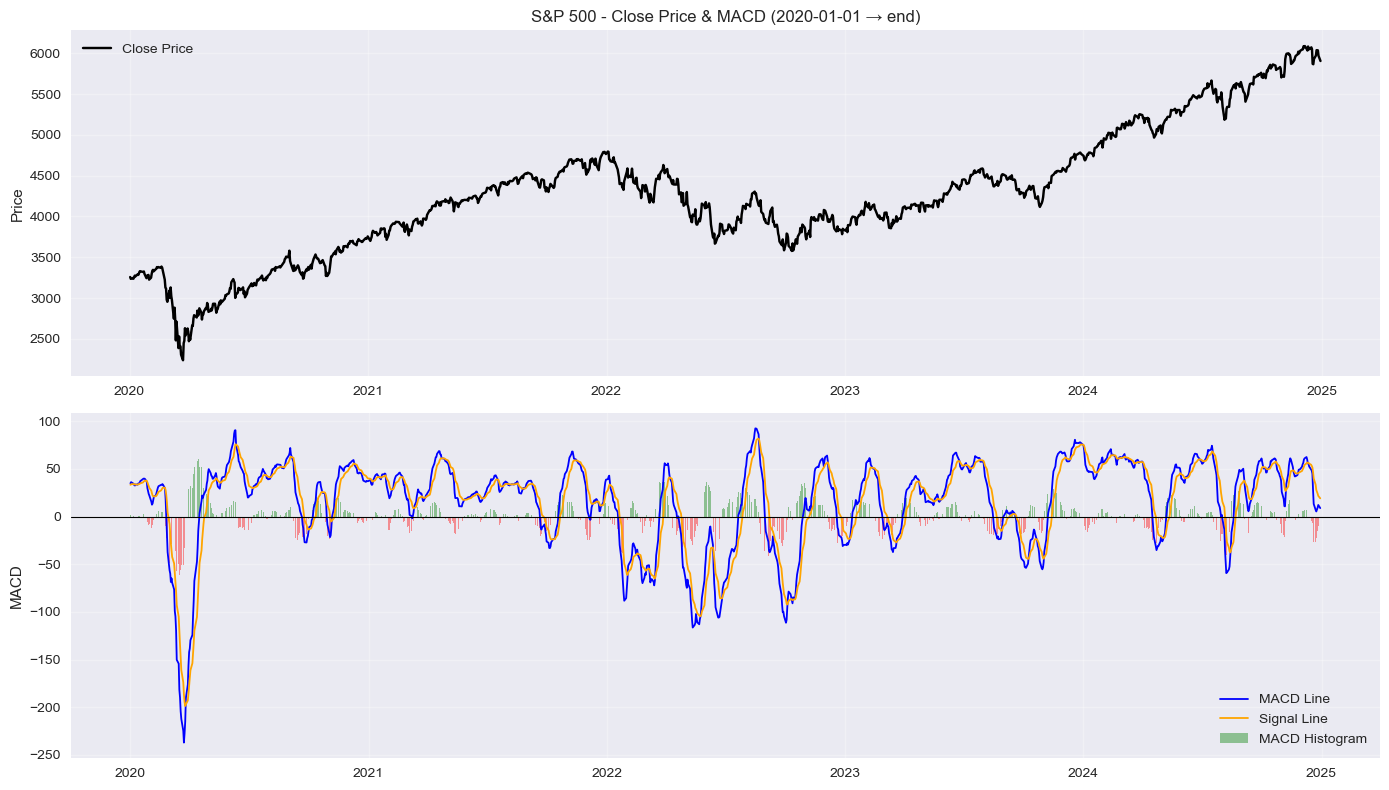

In [7]:
import matplotlib.pyplot as plt

start_plot = "2020-01-01"
data_plot = data.loc[start_plot:]

plt.figure(figsize=(14, 8))

# --- 1) Plot du prix ---
plt.subplot(2, 1, 1)
plt.plot(data_plot.index, data_plot["Close"], label="Close Price", color="black")
plt.title(f"S&P 500 - Close Price & MACD ({start_plot} → end)")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend()

# --- 2) Plot du MACD ---
plt.subplot(2, 1, 2)
plt.plot(data_plot.index, data_plot["MACD_line"], label="MACD Line", color="blue", linewidth=1.3)
plt.plot(data_plot.index, data_plot["MACD_signal"], label="Signal Line", color="orange", linewidth=1.3)

# Histogram
plt.bar(
    data_plot.index,
    data_plot["MACD_hist"],
    label="MACD Histogram",
    color=["green" if v >= 0 else "red" for v in data_plot["MACD_hist"]],
    alpha=0.4
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("MACD")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


## RSI

The Relative Strength Index (RSI) is a momentum oscillator developed by J. Welles Wilder that measures the speed and magnitude of recent price movements to identify overbought or oversold market conditions. It oscillates between 0 and 100, typically using a 14-period window. When RSI rises above 70, it suggests that the asset may be overbought and could experience a pullback; when it falls below 30, it indicates that the asset may be oversold and due for a rebound. In trading and machine-learning contexts, RSI serves as a non-linear feature capturing momentum reversals and exhaustion in trends—helping models detect short-term shifts in market sentiment.

In [8]:
def compute_RSI(series, window=14):
    delta = series.diff()

    # Separate positive and negative changes
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Exponential moving averages (Wilder’s smoothing)
    avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [9]:
data["RSI_14"] = compute_RSI(data["Close"], window=14)

In [10]:
data["RSI_14"] = data["RSI_14"].shift(1)
#to prevent look ahead bias

#clean missing values
data = data.dropna()

display(data[["Close", "RSI_14"]].head())

,Close,RSI_14
Date,,
2018-01-26,2872.870117,87.329050
2018-01-29,2853.530029,90.853112
2018-01-30,2822.429932,77.500066
2018-01-31,2823.810059,61.776478
2018-02-01,2821.979980,62.143533


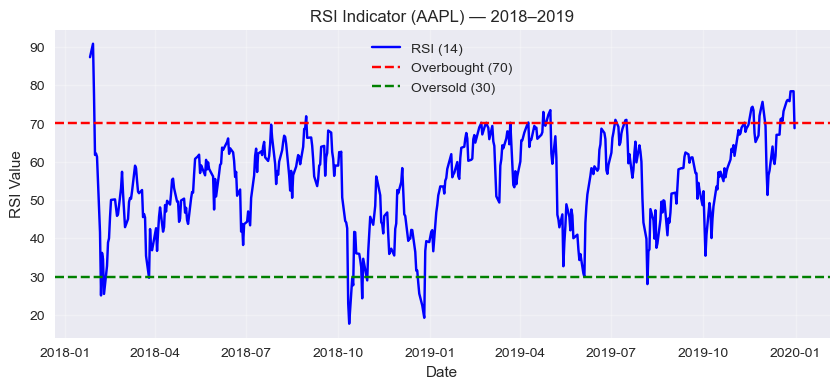

In [11]:
mask = (data.index >= "2018-01-01") & (data.index <= "2019-12-31")
subset = data.loc[mask]
plt.figure(figsize=(10, 4))
plt.plot(subset.index, subset["RSI_14"], label="RSI (14)", color="blue")
plt.axhline(70, color="red", linestyle="--", label="Overbought (70)")
plt.axhline(30, color="green", linestyle="--", label="Oversold (30)")
plt.title("RSI Indicator (AAPL) — 2018–2019")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## EMA

Moving averages smooth the price and help identify trends,the EMA applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. Momentum measures how quickly the price changes over a period (10 or 20 days).
Positive momentum means acceleration upward, negative momentum means downward acceleration.

In [19]:
#Simple Moving Averages
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()

#Exponential Moving Average (EMA)
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()

In [14]:
#difference between price and moving averages
data["Close_minus_SMA20"] = data["Close"] - data["SMA_20"]
data["Close_minus_SMA50"] = data["Close"] - data["SMA_50"]

In [15]:
#momentum indicators
data["momentum_10d"] = data["Close"].pct_change(10)
data["momentum_20d"] = data["Close"].pct_change(20)

In [17]:
#no look ahead bias
cols_to_shift = [
    "SMA_20", "SMA_50", "EMA_20",
    "Close_minus_SMA20", "Close_minus_SMA50",
    "momentum_10d", "momentum_20d"
]

data[cols_to_shift] = data[cols_to_shift].shift(1)

#clean NaN
data = data.dropna()

In [18]:
display(data[[
    "Close", "SMA_20", "SMA_50", "EMA_20",
    "Close_minus_SMA20", "momentum_10d", "momentum_20d"
]].head())

,Close,SMA_20,SMA_50,EMA_20,Close_minus_SMA20,momentum_10d,momentum_20d
Date,,,,,,,
2018-04-11,2642.189941,2670.470996,2705.006597,2656.475075,-57.311084,0.009620,-0.062231
2018-04-12,2663.989990,2664.163501,2700.686597,2656.512698,-7.293384,-0.000632,-0.045328
2018-04-13,2656.300049,2658.007495,2696.459795,2655.148626,-15.817554,0.011318,-0.044523
2018-04-16,2677.840088,2653.732996,2693.290996,2655.990661,10.256995,0.022645,-0.031093
2018-04-17,2706.389893,2649.181494,2689.940796,2656.020126,7.118555,0.005843,-0.033134


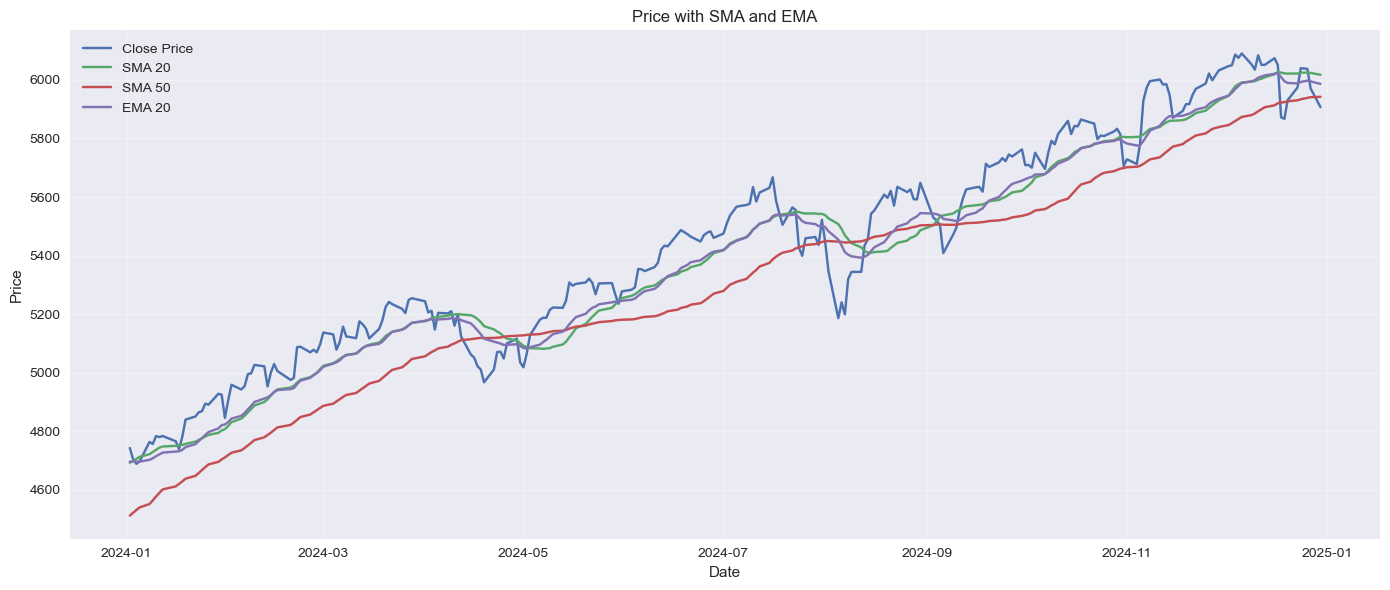

In [22]:
start_plot = "2024-01-01"
plot_data = data.loc[start_plot:]

plt.figure(figsize=(14, 6))

plt.plot(plot_data.index, plot_data["Close"], label="Close Price")
plt.plot(plot_data.index, plot_data["SMA_20"], label="SMA 20")
plt.plot(plot_data.index, plot_data["SMA_50"], label="SMA 50")
plt.plot(plot_data.index, plot_data["EMA_20"], label="EMA 20")

plt.title("Price with SMA and EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

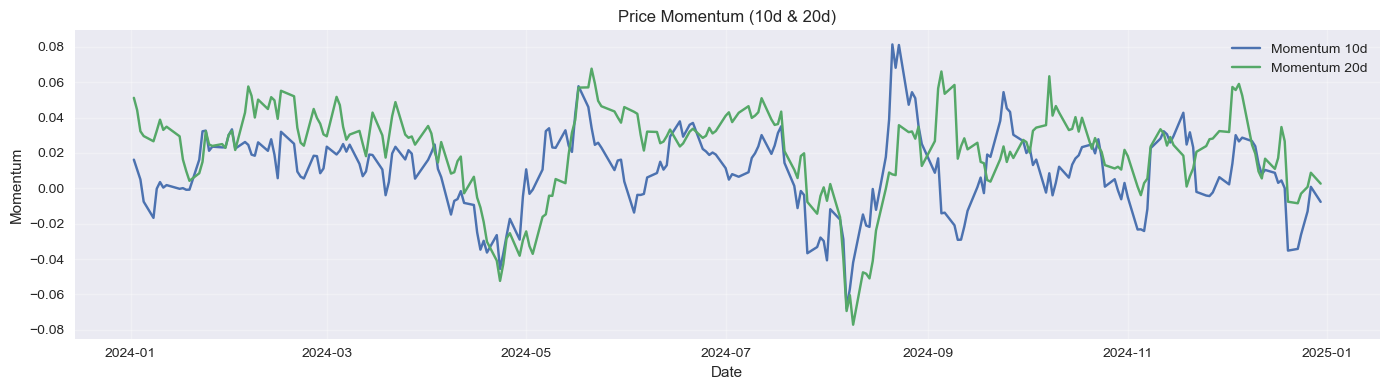

In [23]:
plt.figure(figsize=(14, 4))

plt.plot(plot_data.index, plot_data["momentum_10d"], label="Momentum 10d")
plt.plot(plot_data.index, plot_data["momentum_20d"], label="Momentum 20d")

plt.title("Price Momentum (10d & 20d)")
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()